In [4]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

from twosample import binom_test_two_sided
from multitest import MultiTest
import seaborn

import numpy as np
import scipy


import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm

from scipy.stats import poisson, binom, norm, hypergeom, uniform

import pandas as pd

from sample_survival_data import *
from survival import evaluate_test_stats, multi_pvals
from twosample import binom_test

## Illustrate Curves

In [277]:
def find_changes(Nt1, Nt2, Ot1, Ot2, stbl=False, gamma=.35):
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    mt = MultiTest(pvals[pvals<=1], stbl=stbl) 
    hc, hct = mt.hc(gamma=gamma)
    return pvals <= hct

def illustrate_survival_curve(Nt1, Nt2, Ot1, Ot2, Ct1, Ct2, stbl=False):
    
    stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, stbl=stbl, randomize=False)
    stats_rev = evaluate_test_stats(Nt2, Nt1, Ot2, Ot1, stbl=stbl, randomize=False)
        
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    pvals_rev = multi_pvals(Nt2, Nt1, Ot2, Ot1, randomize=False)
    mt = MultiTest(pvals[pvals<1], stbl=stbl) 
    hc, hct = mt.hc(gamma=.2)
    #print("HC = ", hc)
    fpval = find_changes(Nt1, Nt2, Ot1, Ot2, stbl=True)
    
    dfg = pd.DataFrame()
    dfg['at-risk1'] = Nt1
    dfg['at-risk2'] = Nt2
    dfg['events1'] = Ot1
    dfg['events2'] = Ot2
    dfg['pvalue'] = pvals
    dfg['pvalue_rev'] = pvals_rev
    dfg['Survival Proportion X'] = (Nt1 - Ct1) / (np.max(Nt1) - Ct1)
    dfg['Survival Proportion Y'] = (Nt2 - Ct2) / (np.max(Nt2) - Ct2)
    
    df_disp = dfg[fpval]
    
    plt.step(dfg.index, dfg['Survival Proportion X'], 'b', where='pre')
    plt.step(dfg.index, dfg['Survival Proportion Y'], 'r', where='pre')
    s1 = 100 * Ct1 / np.max(Ct1) # size of censorship markers
    s2 = 100 * Ct2 / np.max(Ct2)
    plt.scatter(dfg.index[Ct1 > 0], dfg.loc[Ct1 > 0,'Survival Proportion X'],
                marker='|', c='k',
                s=s1[Ct1 > 0], alpha=.6)
    plt.scatter(dfg.index[Ct2 > 0], dfg.loc[Ct2 > 0,'Survival Proportion Y'],
                marker='|', c='k',
                s=s2[Ct2 > 0], alpha=.6)
    
    plt.legend([r'$\hat{S}_x$', r'$\hat{S}_y$'], fontsize=16, loc=1)
    
    plt.bar(dfg.index[:len(fpval)], fpval, color='k', alpha=.2, width=.5)
    hc = stats['hc_greater']
    hc_rev = stats_rev['hc_greater']
    logrank = stats['log_rank_greater']

    st_HC = r"$\mathrm{HC}$"
    st_HC_rev = r"$\tilde{\mathrm{HC}}$"
    st_LR = r"$\mathrm{LR}$"
    plt.title(rf"{st_HC}={np.round(hc,2)}, {st_HC_rev}={np.round(hc_rev,2)}, {st_LR}={np.round(logrank,2)}")
    #plt.title(f"{gene_name}, (HC={np.round(stats['hc_greater'],2)}, Log-rank={np.round(stats['log_rank_greater'],2)})")
    plt.ylabel('Survival Proportion', fontsize=16)
    plt.xlabel(r'$t$ (Time)', fontsize=16)
    
    return df_disp, dfg


In [252]:
remote_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/"

<ipython-input-168-7a7507058dce>:33: RuntimeWarning: invalid value encountered in true_divide
  s1 = 50 * Ct1 / np.max(Ct1) # size of censorship markers
<ipython-input-168-7a7507058dce>:34: RuntimeWarning: invalid value encountered in true_divide
  s2 = 50 * Ct2 / np.max(Ct2)


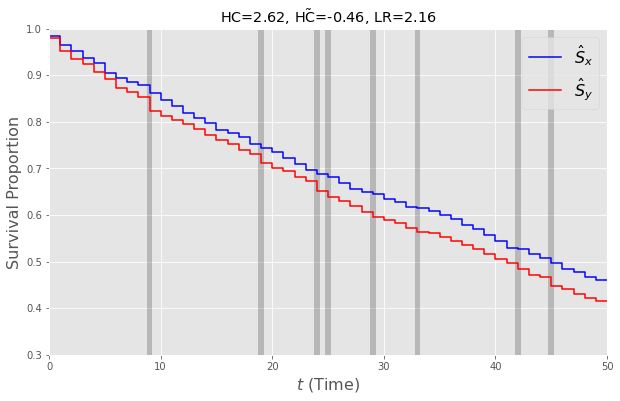

In [169]:
T = 50
N1 = 1000
N2 = 1000
eps = 0.1
lam_bar = 0.75
lam0 = lam_bar / T * np.ones(T)
r = 2
Nt1, Nt2 = sample_survival_data(T, N1, N2, lam0, eps, r)
Ot1 = np.append(-np.diff(Nt1), 0)
Ot2 = np.append(-np.diff(Nt2), 0)

df = pd.DataFrame({
    'at-risk1': Nt1,
    'at-risk2': Nt2,
    'events1': Ot1,
    'events2': Ot2
})

df_small, df_all = illustrate_survival_curve(Nt1, Nt2, Ot1, Ot2,
                                     np.zeros_like(Ot1), np.zeros_like(Ot2), stbl=False)
#plt.title("Hi")
plt.xlim((0,T))
plt.ylim((0.3,1))
#plt.xtickslabel(fontsize=16)
plt.savefig(remote_dir + 'Figs/survival_curve_exm.png')
plt.show()

In [161]:
dfs = df_all.copy()
dfs.index.name='time'

for c in ['at-risk1', 'at-risk2', 'events1', 'events2']:
    dfs[c] = dfs[c].astype(int)
    
dfs['pvalue'] = np.round(dfs['pvalue'], 5)
    
dfs[:-1].filter(['at-risk1', 'at-risk2', 'events1', 'events2', 'pvalue'])\
.to_csv(remote_dir + 'csv/survival_curve_exm.csv')
dfs[:-1]

,at-risk1,at-risk2,events1,events2,pvalue,pvalue_rev,Survival Proportion X,Survival Proportion Y
time,,,,,,,,
0,1000,1000,14,14,0.42722,0.709104,1.000,1.000
1,986,986,24,24,0.98609,0.031841,0.986,0.984
2,962,962,14,14,0.66051,0.489110,0.962,0.972
3,948,948,18,18,0.70965,0.418078,0.948,0.959
4,930,930,16,16,0.83864,0.271816,0.930,0.943
5,914,914,13,13,0.05365,0.974387,0.914,0.931
6,901,901,13,13,0.11632,0.938694,0.901,0.907
7,888,888,14,14,0.57294,0.577694,0.888,0.886
8,874,874,17,17,0.93969,0.123271,0.874,0.872


## With censorship

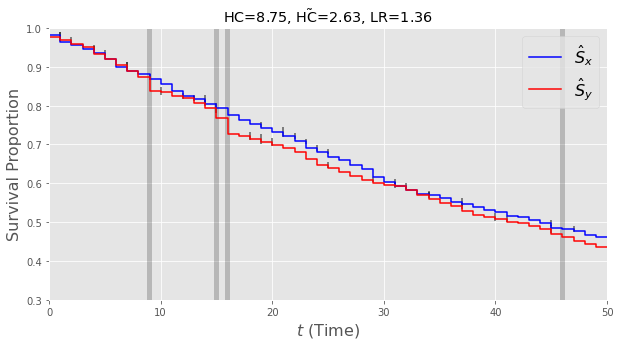

In [286]:

import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [10, 5]
mpl.style.use('ggplot')
%matplotlib inline



T = 50
N1 = 1000
N2 = 1000
eps = 0.1
lam_bar = 0.75
lam0 = lam_bar / T * np.ones(T)
r = 2
Nt1, Nt2 = sample_survival_data(T, N1, N2, lam0, eps, r)
Ct1 = np.append(0, poisson.rvs(.5, size = len(Nt1) - 1))
Ct2 = np.append(0, poisson.rvs(.5, size = len(Nt2) - 1))
Ot1 = np.append(-np.diff(Nt1), 0) - C1
Ot2 = np.append(-np.diff(Nt2), 0) - C2

df = pd.DataFrame({
    'at-risk1': Nt1,
    'at-risk2': Nt2,
    'events1': Ot1,
    'events2': Ot2
})

df_small, df_all = illustrate_survival_curve(Nt1, Nt2, Ot1, Ot2, Ct1, Ct2)

# df1, df2 = illustrate_survival_curve(df, T=100, stbl=False)
plt.xlim((0,T))
plt.ylim((0.3,1))
#plt.xtickslabel(fontsize=16)
plt.savefig(remote_dir + 'Figs/survival_curve_exm.png')
plt.show()
# print(df1)

In [287]:
dfs = df_all.copy()
dfs.index.name='time'

for c in ['at-risk1', 'at-risk2', 'events1', 'events2']:
    dfs[c] = dfs[c].astype(int)
    
dfs['pvalue'] = np.round(dfs['pvalue'], 5)

dfs_all = dfs[:-1].filter(['at-risk1', 'at-risk2', 'events1', 'events2', 'pvalue'])
dfs_all.to_csv(remote_dir + 'csv/survival_curve_exm.csv')
dfs_all[:int(T/2)].to_csv(remote_dir + 'csv/survival_curve_exm_part1.csv')
dfs_all[int(T/2):].to_csv(remote_dir + 'csv/survival_curve_exm_part2.csv')